##### BNS-DTD-from-rprocess.ipynb
### *constraints on binary neutron star delay times from galactic r-process abundance observations*

this notebook plots posterior samples (tmin,alpha) ~ P(tmin,alpha|d) in binary neutron star delay time distribution parameters, conditioned on r-process abundance measurements from galactic stellar spectra, merger rate constraints from gravitational-wave surveys, ejecta expectations from numerical relativity and information about short gamma-ray burst delay times

##### philippe landry (pgjlandry@gmail.com) 02/2024

In [1]:
# import packages

import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal
import numpy.lib.recfunctions as rfn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm

from etc.rProcessUtils import rho_MW
from etc.rProcessChemicalEvolution import rproc_evolution as rproc

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# user input

NSAMP = 100

DTDPATH = 'etc/Zevin22_sgrb_dtd.dat'
EJPATH = 'etc/mej_rate_lcehl_psr+gw+nicer.dat'

OBSPATH = 'etc/Battistini16_disk.csv'
OBSPATH2 = 'etc/SAGA_MP.csv'

SOLARPATH = 'etc/Arnould07_solar_rprocess.dat'

In [3]:
# load DTD parameter and rate-mej samples

alpha, tdmin, tdmax = np.loadtxt(DTDPATH, unpack=True, skiprows=1) # [], [yr], [yr]
tdmin = tdmin/1e9 # convert to Gyr
idxs = np.random.choice(range(len(alpha)),NSAMP,False)
alphas = alpha[idxs]
tdmins = tdmin[idxs]

mej_dyn, mej_dsk, rate = np.loadtxt(EJPATH, unpack=True) # [Msun], [Msun], [MW^-1 Myr^-1]
mej = mej_dyn + mej_dsk
rate = rate*(1e9*rho_MW)/1e6 # convert to Gpc^-3 yr^-1
idxs = np.random.choice(range(len(mej)),NSAMP,False)
rates = rate[idxs]
mejs = mej[idxs]

samples = pd.DataFrame(np.column_stack((alphas,np.log10(tdmins*1e3),rates*mejs*1e6/(1e9*rho_MW)))) # [], [Myr], [MW^-1 Myr^-1]
samples.columns = ['alpha','log10tmin','ratemej']

In [4]:
FeH_tracks, EuFe_tracks = [], []

for i,(alpha,tdmin,rate,mej) in tqdm(enumerate(zip(alphas,tdmins,rates,mejs))):
    
    FeH_track, EuFe_track = rproc(rate,mej,-alpha,tdmin,0.,0.5,5)
    FeH_tracks += [FeH_track]
    EuFe_tracks += [EuFe_track]

0it [00:00, ?it/s]/home/philippe.landry/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/philippe.landry/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: invalid value encountered in divide
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:362: RuntimeWarning: invalid value encountered in divide
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: invalid value encountered in power
  result = C * heaviside(t-tmin,1.) / t**b
100it [01:31,  1.09it

In [5]:
# load Battistini and SAGA data

FeHs, EuFes, FeH_errs, EuFe_errs = np.loadtxt(OBSPATH, unpack=True, delimiter=',', skiprows=1)
FeHs2, EuFes2, FeH_errs2, EuFe_errs2 = np.loadtxt(OBSPATH2, unpack=True, delimiter=',', skiprows=1)

In [6]:
# make gaussian likelihood model for each SAGA datapoint

saga_like_means = []
saga_like_stds = []

for fe,eu,fe_err,eu_err in zip(FeHs, EuFes, FeH_errs, EuFe_errs):

    mean = np.array([fe,eu])
    std = np.array([[fe_err,0.],[0.,eu_err]])
    
    saga_like_means += [mean]
    saga_like_stds += [std]   
    
like_funcs = [multivariate_normal(mean,std) for mean,std in zip(saga_like_means,saga_like_stds)]

In [7]:
fe_grid = np.arange(-3.,0.5,0.05)
log_like, eu_pts_list = [], []

for FeH_track,EuFe_track in tqdm(zip(FeH_tracks,EuFe_tracks)):
    
    curve = np.column_stack((FeH_track,EuFe_track))
    curve = curve[np.where(curve[:,1] >= -5.)[0][0]:]
    curve = curve[~np.isnan(curve[:,1])]
    log_likes = [np.log(np.trapz(like_func.pdf(curve),curve[:,0])) for like_func in like_funcs]
    log_like += [np.sum(log_likes)]
    
    func = interp1d(FeH_track,EuFe_track,bounds_error=False)
    eu_pts = func(fe_grid)
    eu_pts_list += [eu_pts]

100it [00:02, 40.06it/s]


In [8]:
# calculate abundance history confidence envelopes

num_funcs = 10000
eu_pts_disk_idxs = np.random.choice(range(len(eu_pts_list)),num_funcs,True,np.exp(log_like)/np.sum(np.exp(log_like)))
eu_pts_disk_samps = np.array([eu_pts_list[idx] for idx in eu_pts_disk_idxs]).T

mds_disk = [np.nanmedian(eu_pts_disk_samps[i]) for i in range(len(fe_grid))]
lbs_disk = [np.nanquantile(eu_pts_disk_samps[i],0.05) for i in range(len(fe_grid))]
ubs_disk = [np.nanquantile(eu_pts_disk_samps[i],0.95) for i in range(len(fe_grid))]
lbs_disk_std = [np.nanquantile(eu_pts_disk_samps[i],0.16) for i in range(len(fe_grid))]
ubs_disk_std = [np.nanquantile(eu_pts_disk_samps[i],0.84) for i in range(len(fe_grid))]

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


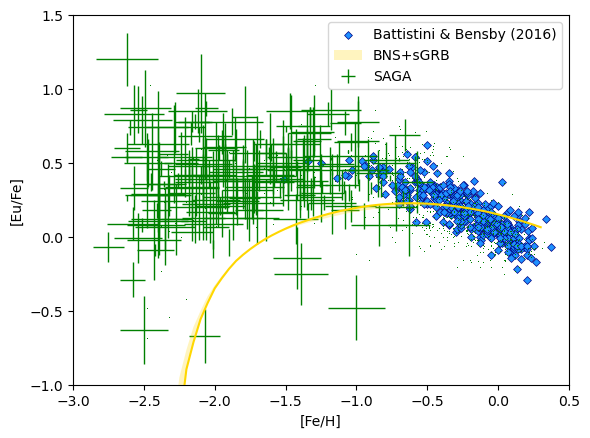

In [9]:
plt.figure(figsize=(6.4,4.8))

plt.errorbar(FeHs2, EuFes2, xerr=[FeH_errs2,FeH_errs2], yerr=[EuFe_errs2,EuFe_errs2], c='g', fmt=',', lw=1, label='SAGA')
plt.scatter(FeHs, EuFes,marker='D',facecolor='dodgerblue',edgecolor='navy', s=16, lw=0.5, label='Battistini & Bensby (2016)')

plt.fill_between(fe_grid,lbs_disk,ubs_disk,facecolor='gold',edgecolor=None,alpha=0.25, label='BNS+sGRB',zorder=10) # 90% CI
plt.fill_between(fe_grid,lbs_disk_std,ubs_disk_std,facecolor='gold',edgecolor=None,alpha=0.5,zorder=10) # 68% CI

plt.plot(fe_grid,mds_disk,c='gold',zorder=10) # median

#for FeH_track,EuFe_track in zip(FeH_tracks,EuFe_tracks):
#    plt.plot(FeH_track,EuFe_track,c='k',alpha=0.05)

plt.xlim(-3.,0.5)
plt.ylim(-1.,1.5)
plt.xlabel('[Fe/H]')
plt.ylabel('[Eu/Fe]')
plt.legend(frameon=True,loc='upper right')
plt.show()

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

<Figure size 640x240 with 0 Axes>

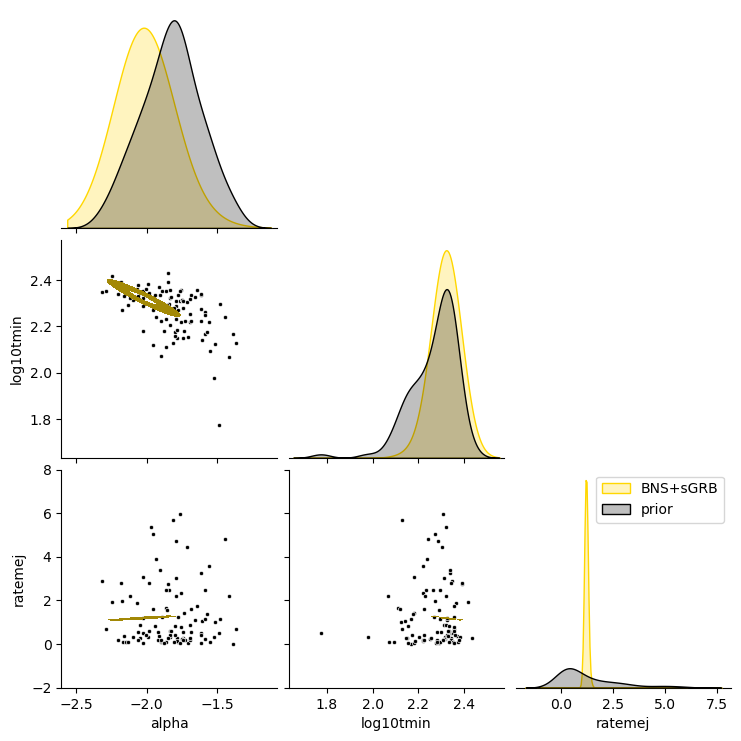

In [10]:
# plot DTD parameter and rate-mej posterior

plt.figure(figsize=(6.4,2.4))

fig = sns.pairplot(samples,vars=['alpha','log10tmin','ratemej'],kind='scatter',diag_kind='kde',plot_kws={'color': 'k'},diag_kws={'weights': np.exp(log_like), 'color': 'gold', 'label': 'BNS+sGRB'},markers='.',corner=True)
fig.map_diag(sns.kdeplot,color='k',fill=True,label='prior')
fig.map_offdiag(sns.kdeplot,levels=[0.5,0.9],weights=np.exp(log_like),color='gold',fill=True)

#labels = ['$m_{ej}R_{MW}$','log10 $t_{min}$']
#for ax, lbl in zip(fig.axes.flatten(), labels):
    # print(ax, lbl)
    #ax.set_ylabel(f'{lbl}')

plt.legend(frameon=True,loc='upper right')
plt.show()